In [ ]:
# !pip install torchvision==0.16.0
# !pip install seaborn
# 安装后点击上方 Restart the kernal

In [2]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
# from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
# 步骤二：加载数据集
# 2.1 设置参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01
ACTIVATION = 'relu'   # 可选 'relu' 或 'sigmoid'
OPTIMIZER = 'sgd'     # 可选 'adam' 或 'sgd'
DROPOUT = False
device = 'cuda'

# 2.2 数据预处理
mean = (0.1307,)
std = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),  # 将 PIL Image 或 numpy.ndarray 转换为 torch.FloatTensor，并将像素强度值从 [0, 255] 缩放到 [0.0, 1.0]
    transforms.Normalize(mean, std)
])

# 2.3 加载训练集和测试集
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=transform,
    download=True
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  # 在每个 epoch 开始时打乱数据顺序，有助于模型训练
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # 测试集通常不需要打乱顺序
)

# for images, labels in train_loader:
#     print(f"Batch of images shape: {images.shape}") # 应该是 [BATCH_SIZE, 1, 28, 28]
#     print(f"Batch of labels shape: {labels.shape}")   # 应该是 [BATCH_SIZE]
#     break

In [7]:
# 步骤三：MLP模型的构建
class MLP(nn.Module):
    def __init__(self,input_dim=28*28, hidden_dim1=256, hidden_dim2=128, output_dim=10):
        super(MLP, self).__init__()
        # 请在此处编写代码：激活函数与Dropout判断
        if ACTIVATION == 'relu':
            activation_layer = nn.ReLU()
        elif ACTIVATION == 'sigmoid':
            activation_layer = nn.Sigmoid()
        layers = [
            # 请在此处编写代码：Flatten + Linear + activation
            nn.Flatten(),  # 将输入的 28x28 图像展平为 784 维向量
            nn.Linear(input_dim, hidden_dim1),
            activation_layer
        ]
        if DROPOUT:
            # 请在此处编写代码：添加Dropout层
            layers.append(nn.Dropout(0.5))
        layers += [
            # 请在此处编写代码：Linear + activation + output
            nn.Linear(hidden_dim1, hidden_dim2),
            activation_layer,
            nn.Linear(hidden_dim2, output_dim)
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp_model = MLP()  # 请在此处编写代码：实例化并迁移模型到GPU
mlp_model.to(device)

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [12]:
# 步骤四：设置损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 请在此处编写代码：交叉熵损失
if OPTIMIZER == 'adam':
    optimizer = optim.Adam(mlp_model.parameters(), lr=LR)  # 请在此处编写代码：Adam优化器
elif OPTIMIZER == 'sgd':
    optimizer = optim.SGD(mlp_model.parameters(), lr=LR, momentum=0.9) # 请在此处编写代码：SGD优化器

lr_scheduler = steps_per_epoch = len(train_loader)
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    epochs=EPOCH,
    steps_per_epoch=steps_per_epoch
)  # 请在此处编写代码：OneCycleLR调度器

In [13]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    mlp_model.train()
    running_loss = 0.0
    # epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # 请在此处编写代码：数据迁移，梯度清零
        outputs = mlp_model(inputs)  # 请在此处编写代码：前向传播，计算loss，反向传播
        # 计算损失
        loss = criterion(outputs, targets)

        # 反向传播：计算损失相对于模型参数的梯度
        loss.backward()

        # 优化器更新：根据梯度更新模型参数
        optimizer.step()
        # 请在此处编写代码：优化器更新，学习率更新
        if lr_scheduler: # 确保 lr_scheduler 存在
            lr_scheduler.step()

        running_loss += loss.item()  # 请在此处编写代码：loss累加与打印

    # 请在此处编写代码：平均loss并添加到train_losses
    avg_epoch_loss = running_loss / len(train_loader)
    train_losses.append(avg_epoch_loss) # 添加到 train_losses 列表
    print(f"\nEpoch {epoch+1}/{EPOCH} - Training Loss: {avg_epoch_loss:.4f}, Current LR: {optimizer.param_groups[0]['lr']:.6f}")

# 5.2 定义测试函数
def test():
    mlp_model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            # 请在此处编写代码：迁移，前向传播，预测
            # 请在此处编写代码：统计正确个数，保存预测和标签
            # 数据迁移到指定设备
            inputs, targets = inputs.to(device), targets.to(device)

            # 前向传播
            outputs = mlp_model(inputs)

            # 获取预测结果 (概率最高的类别)
            # torch.max 返回 (values, indices)，我们取 indices
            _, predicted = torch.max(outputs.data, 1)

            # 统计样本总数和正确预测的个数
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # 保存预测和标签 (确保移回 CPU 以便后续处理，例如使用 scikit-learn)
            all_preds.append(predicted)
            all_labels.append(targets)

    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# 5.3 开始训练和测试
os.makedirs('./output', exist_ok=True)
for epoch in range(EPOCH):
    train(epoch) # 请在此处编写代码：调用train函数
    if (epoch + 1) % 2 == 0:
        # 请在此处编写代码：调用test函数，记录准确率
        print(f"\n--- Testing after Epoch {epoch+1} ---")
        test_acc, _, _ = test() # 当前我们只记录准确率，预测和标签可用于后续分析
        test_accuracies.append(test_acc)
        print(f"--- End of Test for Epoch {epoch+1} ---")

Training Epoch 1: 100%|██████████| 938/938 [00:07<00:00, 123.41it/s]



Epoch 1/10 - Training Loss: 0.8597, Current LR: 0.002802


Training Epoch 2: 100%|██████████| 938/938 [00:07<00:00, 126.23it/s]



Epoch 2/10 - Training Loss: 0.2186, Current LR: 0.007603

--- Testing after Epoch 2 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 134.91it/s]


--- End of Test for Epoch 2 ---


Training Epoch 3: 100%|██████████| 938/938 [00:07<00:00, 119.47it/s]



Epoch 3/10 - Training Loss: 0.1259, Current LR: 0.010000


Training Epoch 4: 100%|██████████| 938/938 [00:07<00:00, 127.13it/s]



Epoch 4/10 - Training Loss: 0.0837, Current LR: 0.009504

--- Testing after Epoch 4 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 139.33it/s]


--- End of Test for Epoch 4 ---


Training Epoch 5: 100%|██████████| 938/938 [00:07<00:00, 126.34it/s]



Epoch 5/10 - Training Loss: 0.0606, Current LR: 0.008116


Training Epoch 6: 100%|██████████| 938/938 [00:07<00:00, 127.78it/s]



Epoch 6/10 - Training Loss: 0.0446, Current LR: 0.006110

--- Testing after Epoch 6 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 142.18it/s]


--- End of Test for Epoch 6 ---


Training Epoch 7: 100%|██████████| 938/938 [00:07<00:00, 127.43it/s]



Epoch 7/10 - Training Loss: 0.0328, Current LR: 0.003885


Training Epoch 8: 100%|██████████| 938/938 [00:07<00:00, 128.22it/s]



Epoch 8/10 - Training Loss: 0.0229, Current LR: 0.001881

--- Testing after Epoch 8 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 140.12it/s]


--- End of Test for Epoch 8 ---


Training Epoch 9: 100%|██████████| 938/938 [00:07<00:00, 122.40it/s]



Epoch 9/10 - Training Loss: 0.0165, Current LR: 0.000494


Training Epoch 10: 100%|██████████| 938/938 [00:07<00:00, 124.01it/s]



Epoch 10/10 - Training Loss: 0.0137, Current LR: 0.000000

--- Testing after Epoch 10 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 139.56it/s]

--- End of Test for Epoch 10 ---


Testing: 100%|██████████| 157/157 [00:01<00:00, 136.13it/s]



Final Test Accuracy: 98.09%


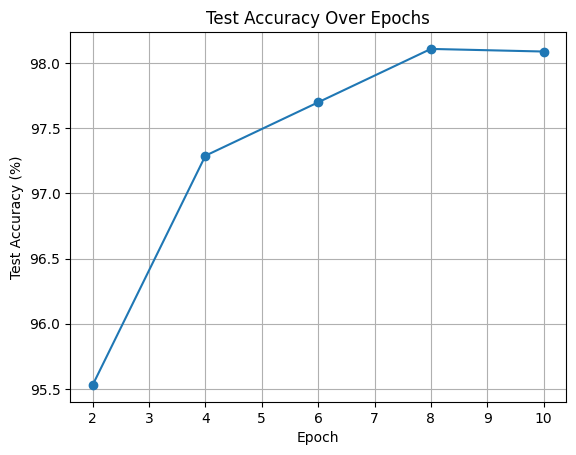

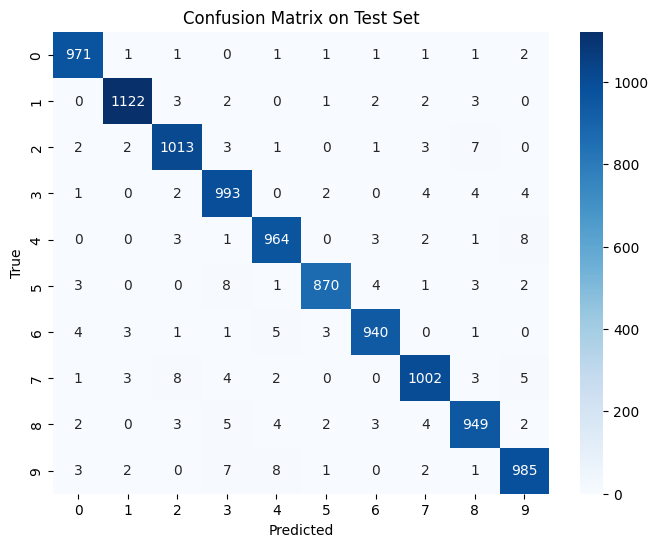

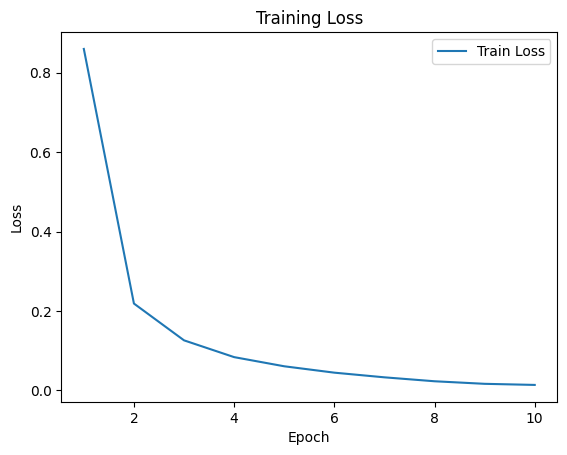

********Prediction Samples********
Predicted labels: [7 2 1 0 4 1 4 9 6 9]
Actual labels:    [7 2 1 0 4 1 4 9 5 9]


In [15]:
# 步骤六：模型评估
# 6.1 最后一次完整测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

pred_y = pred_y.cpu()
true_y = true_y.cpu()

# 6.2 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(2, EPOCH+1, 2), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.savefig('./output/accuracy_curve.png')
plt.show()

# 6.3 绘制混淆矩阵
conf_mat = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.4 绘制训练 loss 曲线图
plt.figure()
plt.plot(range(1, EPOCH+1, 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./output/loss_curve.png')
plt.show()

# 6.5 打印前10个样本预测
print('********Prediction Samples********')
print("Predicted labels:", pred_y[:10].numpy())
print("Actual labels:   ", true_y[:10].numpy())

In [ ]:
# 步骤七：保存模型
# 请在此处编写代码：保存模型

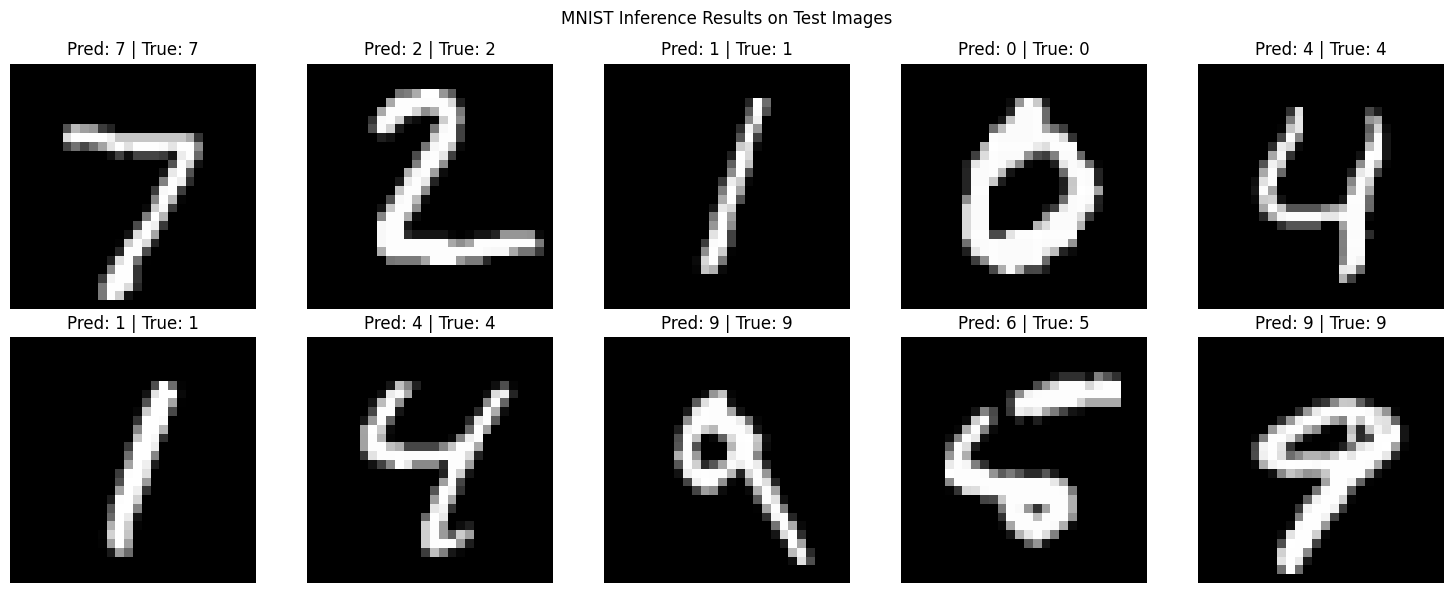

In [17]:
# 步骤八：推理结果可视化（MNIST专用）
def visualize_mnist_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 MNIST 测试集上的部分预测结果（灰度图）
    """
    model.eval()  # 请在此处编写代码：切换模型为eval模式
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 请在此处编写代码：将inputs和targets迁移到设备
            outputs = model(inputs)  # 请在此处编写代码：前向传播
            _, predicted = torch.max(outputs, 1)  # 请在此处编写代码：获取预测类别

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                # img = ...  # 请在此处编写代码：获取第i张图像并转为(28,28) numpy格式
                img_tensor = inputs[i].cpu().squeeze() # Squeeze to remove channel dim if it's 1
                img_numpy = img_tensor.numpy()
                true_label = targets[i].cpu().item()  # 请在此处编写代码：获取真实标签
                pred_label = predicted[i].cpu().item()  # 请在此处编写代码：获取预测标签

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img_numpy, cmap='gray')
                plt.title(f"Pred: {pred_label} | True: {true_label}")
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("MNIST Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/mnist_test_predictions.png')
    plt.show()


# 调用推理可视化函数
visualize_mnist_predictions(mlp_model, test_loader, device=device, num_images=10)